In [81]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from pandas import DataFrame

from dataflow import df_train, df_test, df_geography, df_product

In [11]:
# Kết nối tự nhiên giữa các bảng
df = df_train.merge(df_geography, on='Zip', how='left').merge(df_product, on='ProductID', how='left')

In [50]:
df.head(10)

,ProductID,Date,Zip,Units,Revenue,COGS,City,State,Region,District,Category,Segment,Product
0,1228,2013-07-31,78773,12,19648.44,12309.747660,"Austin, TX",TX,Central,District #23,Urban,Convenience,Pirum UC-30
1,781,2014-03-12,90501,16,20351.52,13497.128064,"Torrance, CA",CA,West,District #37,Rural,Productivity,Natura RP-69
2,2090,2013-11-29,44460,26,111367.62,91488.499830,"Salem, OH",OH,East,District #14,Urban,Convenience,Currus UC-25
3,1116,2018-08-29,30122,12,36280.44,21967.806420,"Lithia Springs, GA",GA,East,District #09,Rural,Select,Pirum RS-04
4,993,2013-04-27,75789,14,55557.18,48645.866808,"Troup, TX",TX,Central,District #24,Urban,Convenience,Natura UC-56
5,715,2014-12-29,27707,12,23806.44,21909.066732,"Durham, NC",NC,East,District #08,Rural,Productivity,Natura RP-03
6,808,2016-11-25,77041,13,53636.31,31693.695579,"Houston, TX",TX,Central,District #23,Rural,Select,Natura RS-12
7,764,2012-01-27,27522,40,146134.80,135496.186560,"Creedmoor, NC",NC,East,District #08,Rural,Productivity,Natura RP-52
8,433,2016-04-17,90250,21,240719.85,137451.034350,"Hawthorne, CA",CA,West,District #37,Urban,Moderation,Maximus UM-38
9,1244,2017-01-06,33178,17,98510.58,71016.277122,"Miami, FL",FL,East,District #10,Mix,Productivity,Quibus MP-12


In [39]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

In [ ]:
def plot_overall(df: pd.DataFrame, title: str, display: str, color: str = 'blue') -> None:
    # Chuyển đổi cột Date về dạng datetime nếu chưa
    df['Date'] = pd.to_datetime(df['Date'])

    # Tạo các nhóm theo Tuần, Tháng, Quý, Năm
    df_weekly = df.resample('W', on='Date')[title].sum()
    df_monthly = df.resample('ME', on='Date')[title].sum()
    df_quarterly = df.resample('QE', on='Date')[title].sum()
    df_yearly = df.resample('YE', on='Date')[title].sum()

    # Hàm định dạng trục y (hiển thị dạng 1.0, 2.0,...)
    def y_formatter(x, pos):
        power = int("{:e}".format(x).split('e')[1]) if x != 0 else 0
        return f'{x / 10**power:.1f}'

    # Vẽ biểu đồ
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))

    for ax, data, label in zip(
        [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]],
        [df_weekly, df_monthly, df_quarterly, df_yearly],
        ['Tuần', 'Tháng', 'Quý', 'Năm']
    ):
        ax.plot(data.index, data.values, linestyle='-', color=color)
        ax.set_title(f'Tổng {display} Theo {label}')
        ax.set_xlabel('Thời gian')
        ax.set_ylabel(display)

        # Định dạng trục y
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(y_formatter))

        # Lấy bậc của 10 cao nhất để hiển thị chú thích trên góc
        max_val = data.max()
        if max_val > 0:
            power = int("{:e}".format(max_val).split('e')[1])
            ax.yaxis.offsetText.set_visible(False)  # Ẩn mặc định offset của matplotlib
            ax.text(0.98, 0.98, f'1e{power}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

    # Tự động căn chỉnh layout
    plt.tight_layout()
    plt.show()

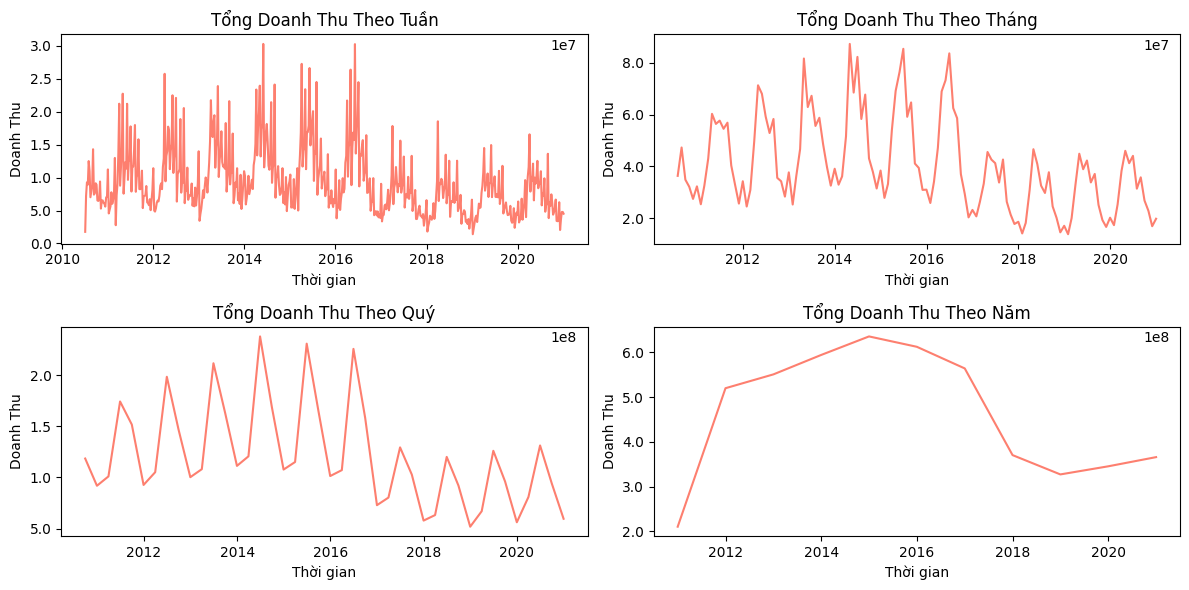

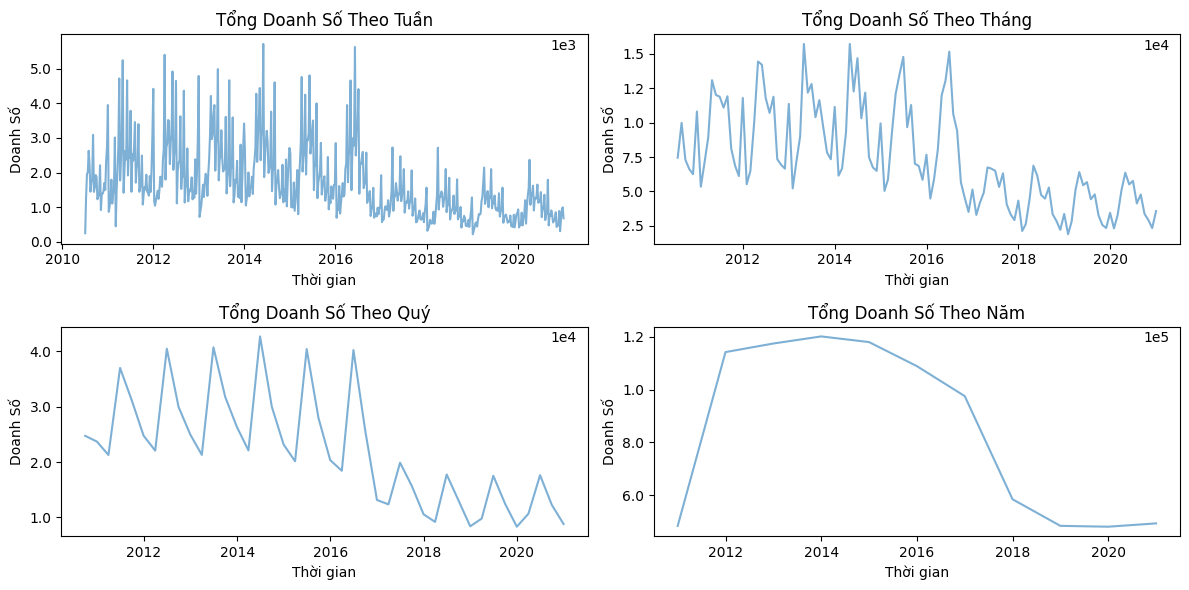

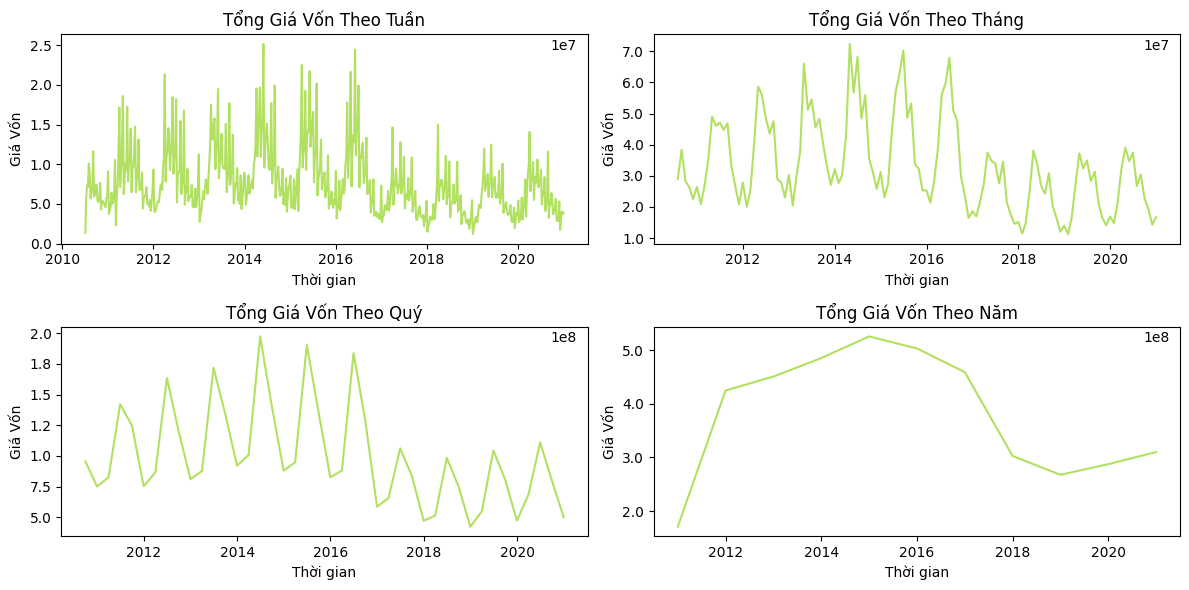

In [40]:
plot_overall(df, 'Revenue', 'Doanh Thu', colors[0])
plot_overall(df, 'Units', 'Doanh Số', colors[1])
plot_overall(df, 'COGS', 'Giá Vốn', colors[2])

In [60]:
def plot_top_bottom(df, group_col, title_prefix):
    """
    Vẽ 6 subplot cho top 10 nhóm và có thể vẽ thêm 6 subplot cho top 10 thấp nhất.
    
    Parameters:
    - df: DataFrame chứa dữ liệu
    - group_col: Cột để nhóm dữ liệu (Product, State, City)
    - title_prefix: Tiêu đề chung cho các biểu đồ (Ví dụ: 'Sản phẩm', 'Bang', 'Thành phố')
    """

    # Nhóm dữ liệu theo group_col và tính tổng các chỉ số
    grouped_data = df.groupby(group_col).agg({'Revenue': 'sum', 'Units': 'sum', 'COGS': 'sum'})

    # Nếu số lượng nhóm <= 10, chỉ vẽ top 10 cao nhất
    plot_bottom = len(grouped_data) > 10  

    # Xếp hạng từng tiêu chí
    grouped_data['Rank_Revenue'] = grouped_data['Revenue'].rank(ascending=False, method='min')
    grouped_data['Rank_Units'] = grouped_data['Units'].rank(ascending=False, method='min')
    grouped_data['Rank_COGS'] = grouped_data['COGS'].rank(ascending=False, method='min')

    # Tính Rank Sum cho từng cặp tiêu chí
    grouped_data['RankSum_Revenue_Units'] = grouped_data['Rank_Revenue'] + grouped_data['Rank_Units']
    grouped_data['RankSum_Revenue_COGS'] = grouped_data['Rank_Revenue'] + grouped_data['Rank_COGS']
    grouped_data['RankSum_Units_COGS'] = grouped_data['Rank_Units'] + grouped_data['Rank_COGS']

    # Lấy top 10 nhóm theo từng tiêu chí riêng lẻ
    top_revenue = grouped_data.nlargest(10, 'Revenue')
    top_units = grouped_data.nlargest(10, 'Units')
    top_cogs = grouped_data.nlargest(10, 'COGS')

    # Lấy top 10 theo Rank Sum của từng cặp tiêu chí
    top_rank_revenue_units = grouped_data.nsmallest(10, 'RankSum_Revenue_Units')
    top_rank_revenue_cogs = grouped_data.nsmallest(10, 'RankSum_Revenue_COGS')
    top_rank_units_cogs = grouped_data.nsmallest(10, 'RankSum_Units_COGS')

    # Nếu đủ điều kiện, lấy top 10 thấp nhất
    if plot_bottom:
        bottom_revenue = grouped_data.nsmallest(10, 'Revenue')
        bottom_units = grouped_data.nsmallest(10, 'Units')
        bottom_cogs = grouped_data.nsmallest(10, 'COGS')
        bottom_rank_revenue_units = grouped_data.nlargest(10, 'RankSum_Revenue_Units')
        bottom_rank_revenue_cogs = grouped_data.nlargest(10, 'RankSum_Revenue_COGS')
        bottom_rank_units_cogs = grouped_data.nlargest(10, 'RankSum_Units_COGS')

    # Xác định số hàng cần vẽ
    num_rows = 4 if plot_bottom else 2

    # Tạo figure với subplot (2 hoặc 4 hàng, 3 cột)
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))

    # Biểu đồ top 10 theo doanh thu
    axes[0, 0].barh(top_revenue.index[::-1], top_revenue['Revenue'][::-1], color=colors[0])
    axes[0, 0].set_title(f'Top 10 {title_prefix} Theo Doanh Thu')
    axes[0, 0].set_xlabel('Doanh thu')
    axes[0, 0].set_ylabel(title_prefix)

    # Biểu đồ top 10 theo doanh số
    axes[0, 1].barh(top_units.index[::-1], top_units['Units'][::-1], color=colors[1])
    axes[0, 1].set_title(f'Top 10 {title_prefix} Theo Doanh Số')
    axes[0, 1].set_xlabel('Doanh số')

    # Biểu đồ top 10 theo giá vốn
    axes[0, 2].barh(top_cogs.index[::-1], top_cogs['COGS'][::-1], color=colors[2])
    axes[0, 2].set_title(f'Top 10 {title_prefix} Theo Giá Vốn')
    axes[0, 2].set_xlabel('Giá vốn')

    # Biểu đồ top 10 theo Rank Sum (Doanh Thu + Doanh Số)
    axes[1, 0].barh(top_rank_revenue_units.index[::-1], top_rank_revenue_units['RankSum_Revenue_Units'][::-1], color=colors[3])
    axes[1, 0].set_title(f'Top 10 {title_prefix} (Doanh Thu + Doanh Số)')
    axes[1, 0].set_xlabel('Rank Sum')

    # Biểu đồ top 10 theo Rank Sum (Doanh Thu + Giá Vốn)
    axes[1, 1].barh(top_rank_revenue_cogs.index[::-1], top_rank_revenue_cogs['RankSum_Revenue_COGS'][::-1], color=colors[4])
    axes[1, 1].set_title(f'Top 10 {title_prefix} (Doanh Thu + Giá Vốn)')
    axes[1, 1].set_xlabel('Rank Sum')

    # Biểu đồ top 10 theo Rank Sum (Doanh Số + Giá Vốn)
    axes[1, 2].barh(top_rank_units_cogs.index[::-1], top_rank_units_cogs['RankSum_Units_COGS'][::-1], color=colors[5])
    axes[1, 2].set_title(f'Top 10 {title_prefix} (Doanh Số + Giá Vốn)')
    axes[1, 2].set_xlabel('Rank Sum')

    # Nếu có đủ dữ liệu, vẽ thêm 6 subplot cho top thấp nhất
    if plot_bottom:
        axes[2, 0].barh(bottom_revenue.index[::-1], bottom_revenue['Revenue'][::-1], color=colors[0])
        axes[2, 0].set_title(f'Bottom 10 {title_prefix} Theo Doanh Thu')
        axes[2, 0].set_xlabel('Doanh thu')
        axes[2, 0].set_ylabel(title_prefix)

        axes[2, 1].barh(bottom_units.index[::-1], bottom_units['Units'][::-1], color=colors[1])
        axes[2, 1].set_title(f'Bottom 10 {title_prefix} Theo Doanh Số')
        axes[2, 1].set_xlabel('Doanh số')

        axes[2, 2].barh(bottom_cogs.index[::-1], bottom_cogs['COGS'][::-1], color=colors[2])
        axes[2, 2].set_title(f'Bottom 10 {title_prefix} Theo Giá Vốn')
        axes[2, 2].set_xlabel('Giá vốn')

        axes[3, 0].barh(bottom_rank_revenue_units.index[::-1], bottom_rank_revenue_units['RankSum_Revenue_Units'][::-1], color=colors[3])
        axes[3, 0].set_title(f'Bottom 10 {title_prefix} (Doanh Thu + Doanh Số)')
        axes[3, 0].set_xlabel('Rank Sum')

        axes[3, 1].barh(bottom_rank_revenue_cogs.index[::-1], bottom_rank_revenue_cogs['RankSum_Revenue_COGS'][::-1], color=colors[4])
        axes[3, 1].set_title(f'Bottom 10 {title_prefix} (Doanh Thu + Giá Vốn)')
        axes[3, 1].set_xlabel('Rank Sum')

        axes[3, 2].barh(bottom_rank_units_cogs.index[::-1], bottom_rank_units_cogs['RankSum_Units_COGS'][::-1], color=colors[5])
        axes[3, 2].set_title(f'Bottom 10 {title_prefix} (Doanh Số + Giá Vốn)')
        axes[3, 2].set_xlabel('Rank Sum')

    # Căn chỉnh bố cục
    plt.tight_layout()
    plt.show()


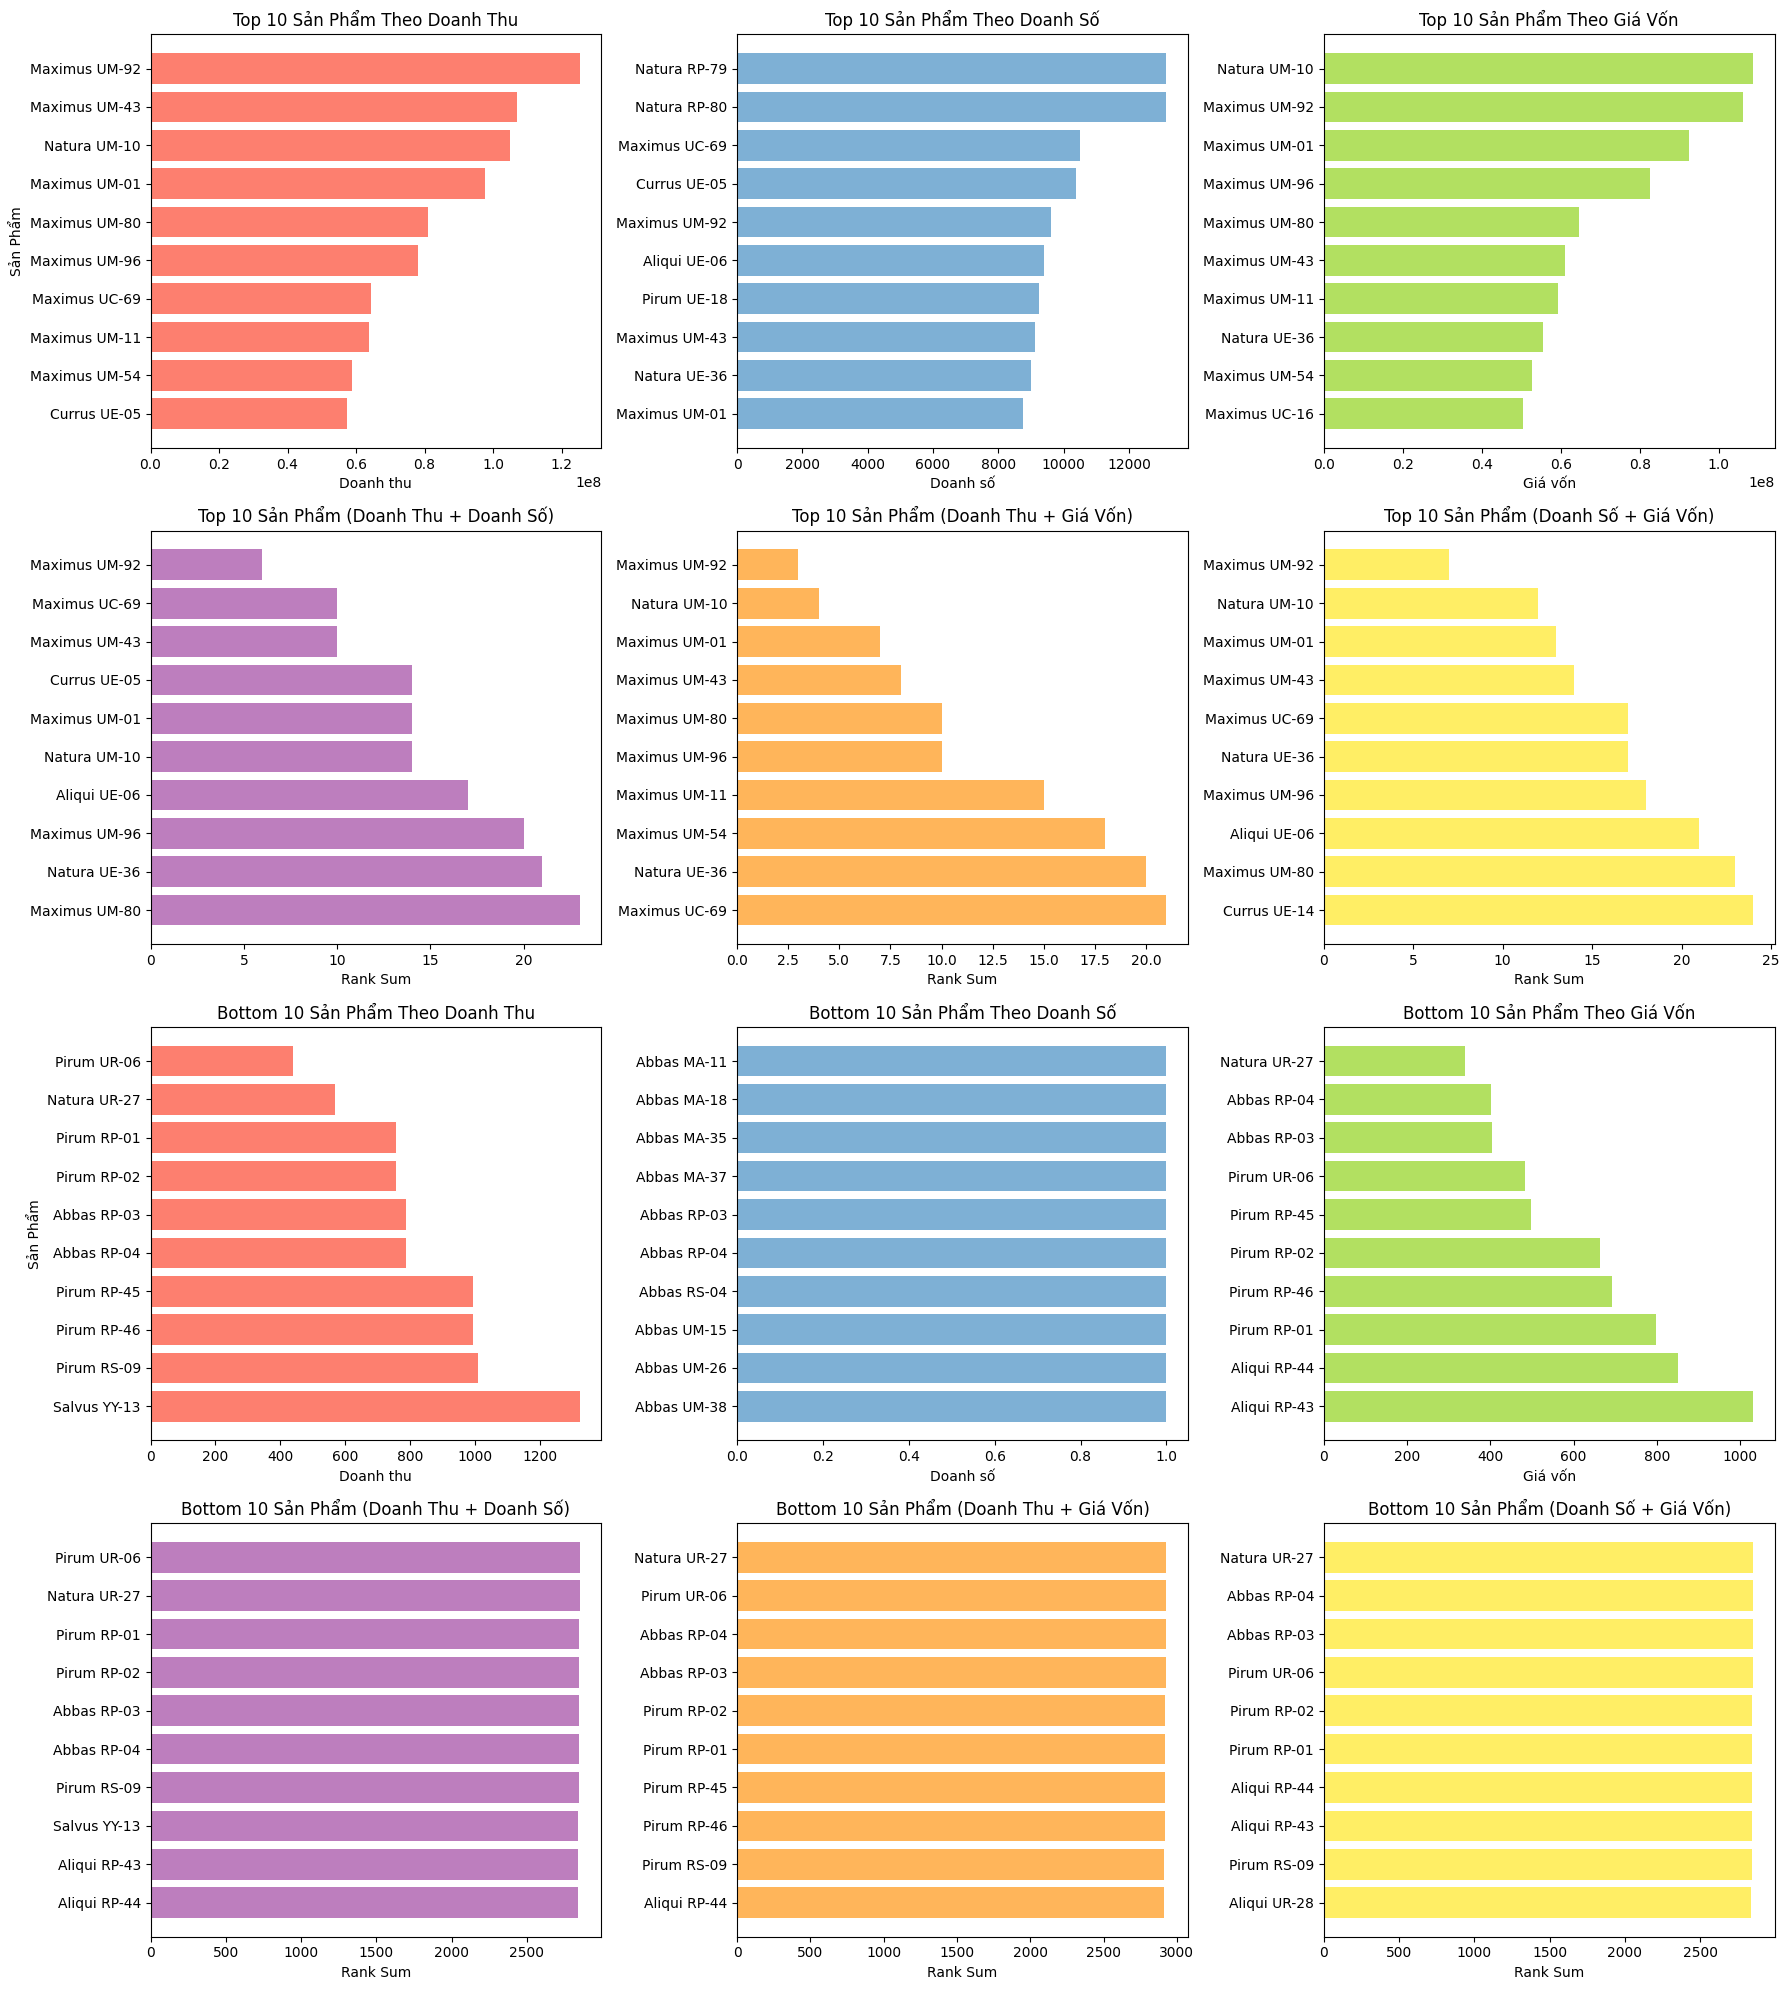

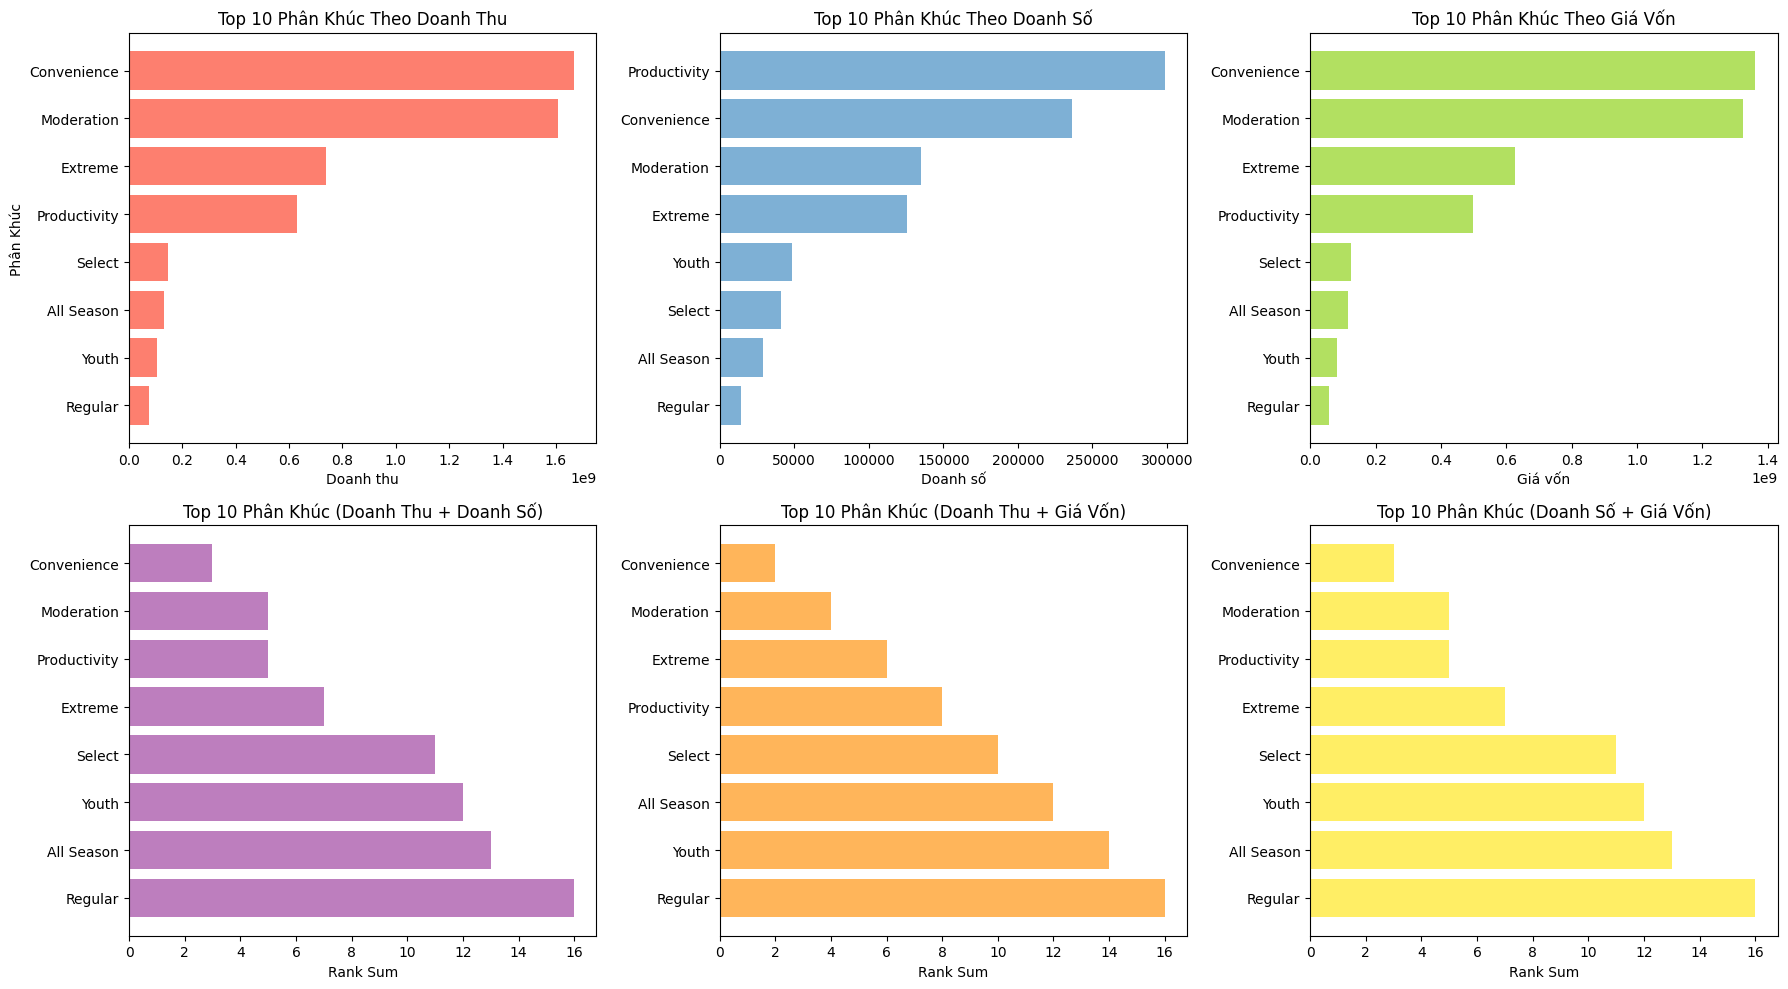

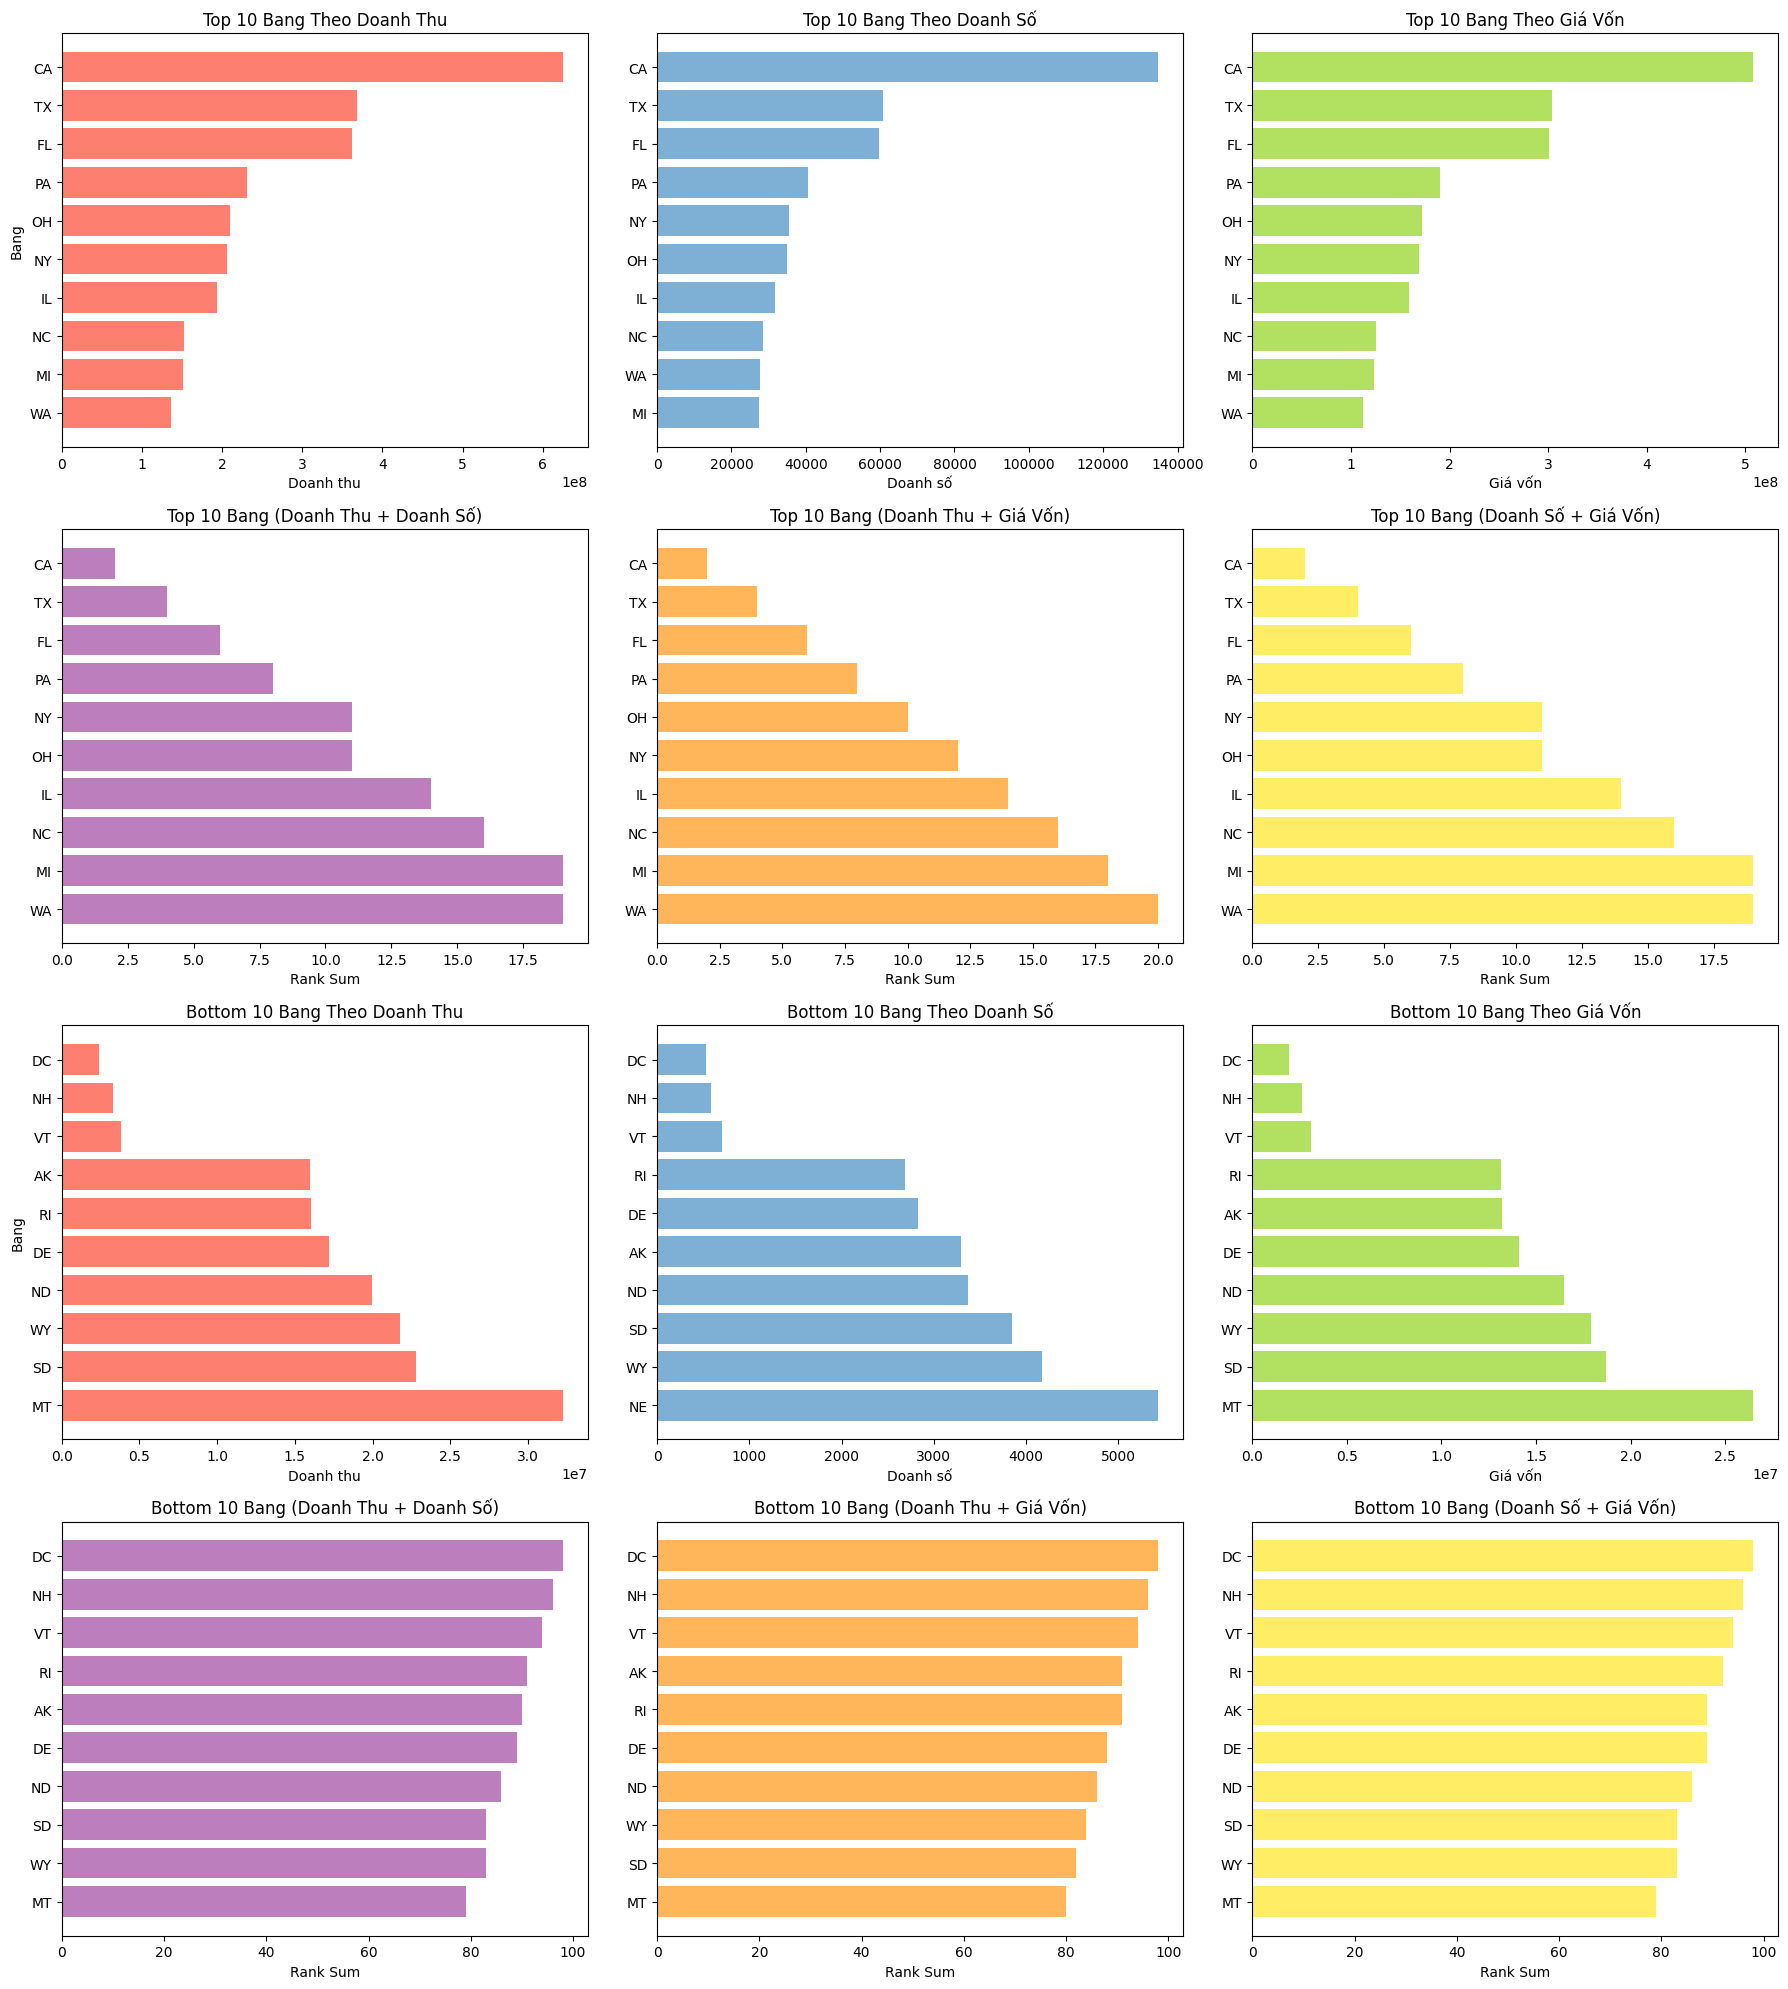

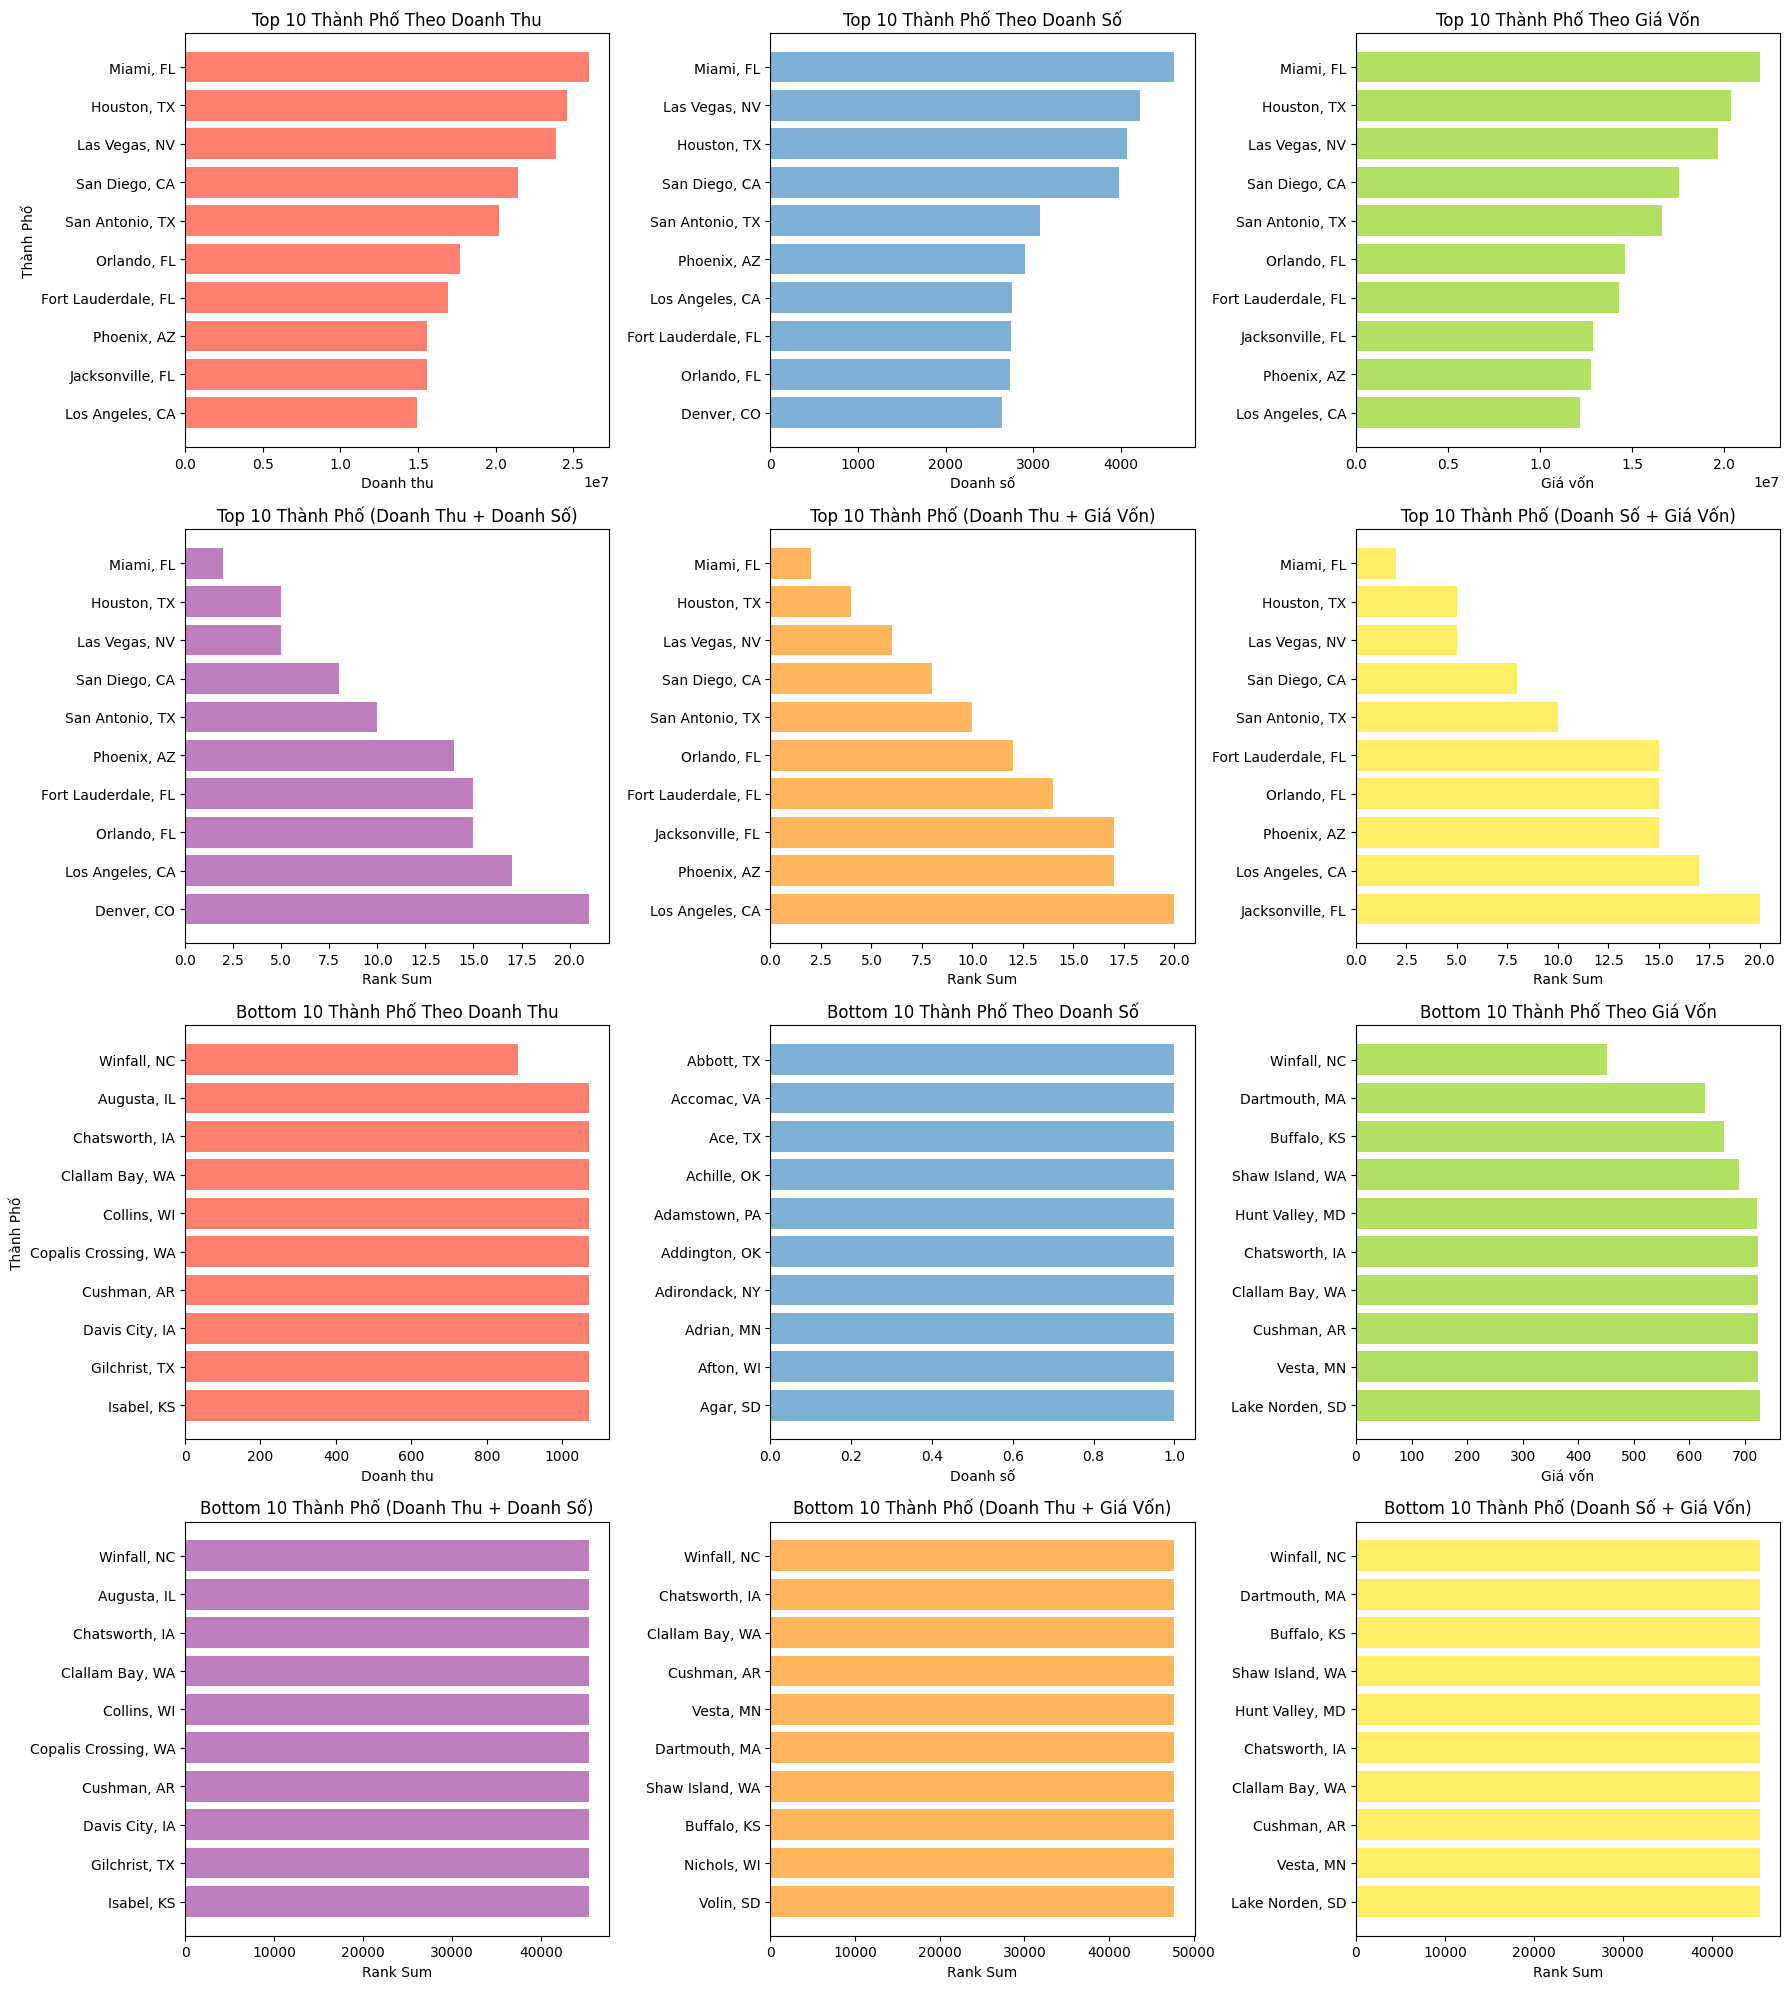

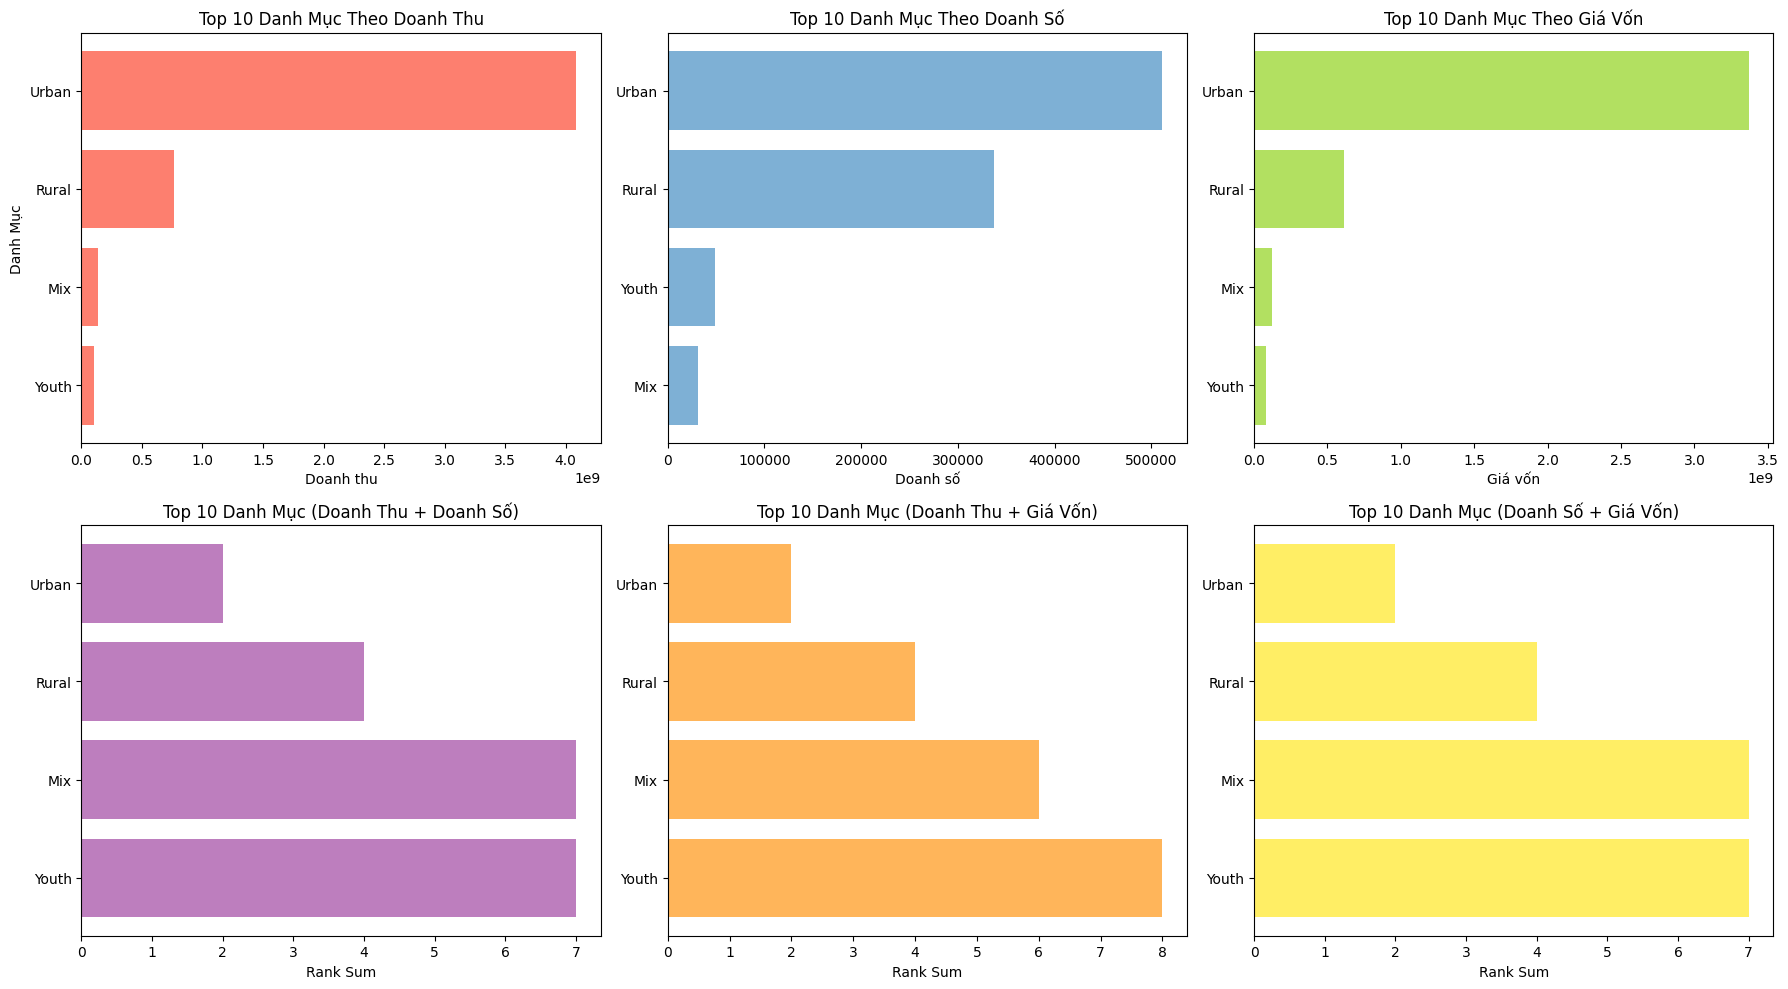

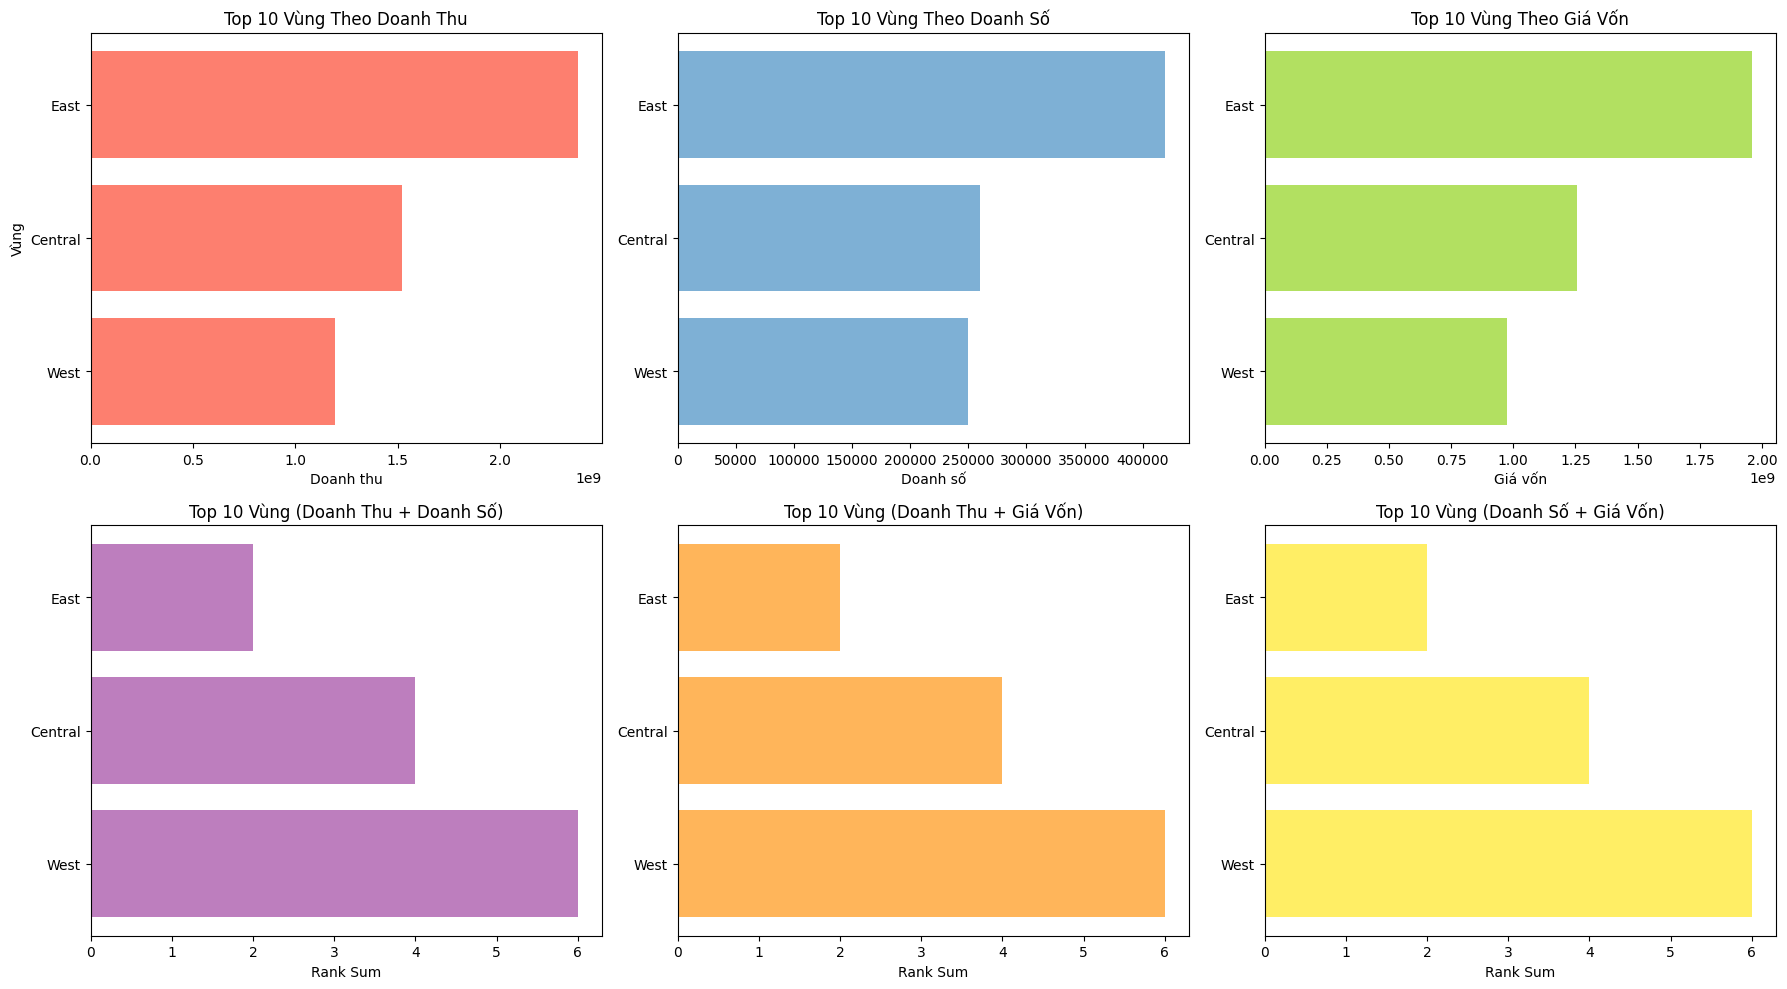

In [62]:
plot_top_bottom(df, 'Product', 'Sản Phẩm')
plot_top_bottom(df, 'Segment', 'Phân Khúc')
plot_top_bottom(df, 'State', 'Bang')
plot_top_bottom(df, 'City', 'Thành Phố')
plot_top_bottom(df, 'Category', 'Danh Mục')
plot_top_bottom(df, 'Region', 'Vùng')

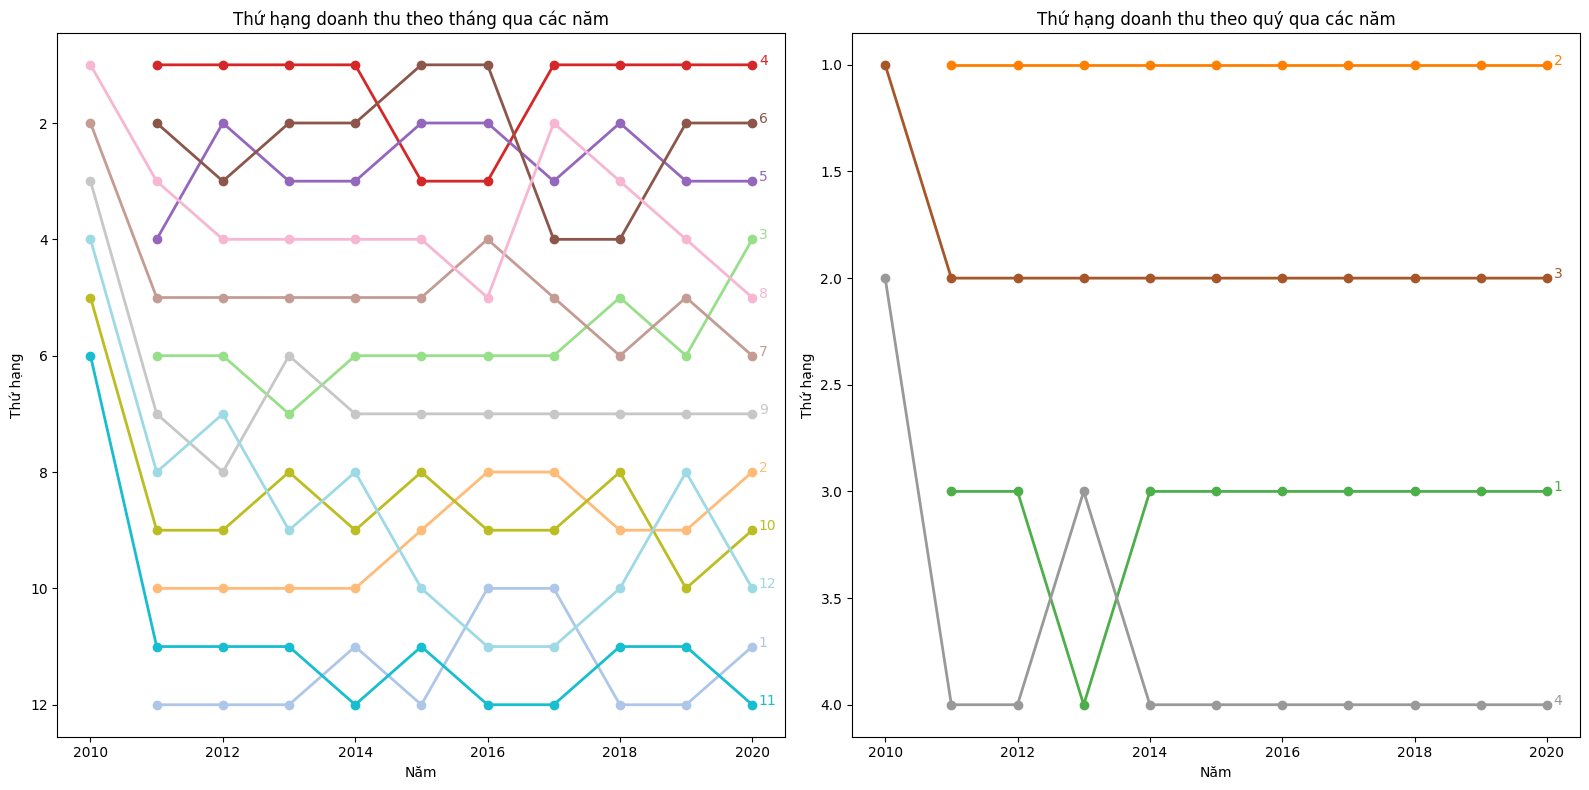

In [82]:
# Giả sử df đã có cột Date dạng datetime và cột Revenue
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

# --- Tính tổng doanh thu theo tháng ---
month_group = df.groupby(['Year', 'Month'])['Revenue'].sum().reset_index()
# Xếp hạng các tháng trong mỗi năm (Rank 1: doanh thu cao nhất)
month_group['Rank'] = month_group.groupby('Year')['Revenue'].rank(ascending=False, method='min')

# --- Tính tổng doanh thu theo quý ---
quarter_group = df.groupby(['Year', 'Quarter'])['Revenue'].sum().reset_index()
quarter_group['Rank'] = quarter_group.groupby('Year')['Revenue'].rank(ascending=False, method='min')

# Tạo figure với 2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Bump Chart cho các tháng ---
# Sử dụng colormap 'tab20' cho 12 màu khác nhau
month_cmap = matplotlib.colormaps['tab20']
for m in sorted(month_group['Month'].unique()):
    data = month_group[month_group['Month'] == m].sort_values('Year')
    # Lấy màu theo tỷ lệ (m/12) để đảm bảo phân bố đều trong colormap
    color = month_cmap(m / 12)
    axes[0].plot(data['Year'], data['Rank'], marker='o', color=color, lw=2)
    # Ghi nhãn tháng tại điểm cuối (năm mới nhất)
    last_year = data['Year'].max()
    last_rank = data.loc[data['Year'] == last_year, 'Rank'].values[0]
    axes[0].text(last_year + 0.1, last_rank, m, color=color, fontsize=10)

axes[0].set_title('Thứ hạng doanh thu theo tháng qua các năm')
axes[0].set_xlabel('Năm')
axes[0].set_ylabel('Thứ hạng')
axes[0].invert_yaxis()  # Đảo ngược trục y để Rank 1 nằm trên cùng

# --- Bump Chart cho các quý ---
# Sử dụng colormap 'Set1' cho 4 màu khác biệt
quarter_cmap = matplotlib.colormaps['Set1']
for q in sorted(quarter_group['Quarter'].unique()):
    data = quarter_group[quarter_group['Quarter'] == q].sort_values('Year')
    color = quarter_cmap(q / 4)
    axes[1].plot(data['Year'], data['Rank'], marker='o', color=color, lw=2)
    last_year = data['Year'].max()
    last_rank = data.loc[data['Year'] == last_year, 'Rank'].values[0]
    axes[1].text(last_year + 0.1, last_rank, q, color=color, fontsize=10)

axes[1].set_title('Thứ hạng doanh thu theo quý qua các năm')
axes[1].set_xlabel('Năm')
axes[1].set_ylabel('Thứ hạng')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


=== Kiểm định ADF cho chuỗi gốc ===
ADF Test cho Revenue (Tuần):
  ADF Statistic: -5.2091
  p-value: 0.0000

ADF Test cho Revenue (Tháng):
  ADF Statistic: -0.6036
  p-value: 0.8702

ADF Test cho Revenue (Quý):
  ADF Statistic: -0.9633
  p-value: 0.7664

ADF Test cho Revenue (Năm):
  ADF Statistic: -1.0192
  p-value: 0.7462

ADF Test cho Units (Tuần):
  ADF Statistic: -3.4712
  p-value: 0.0088

ADF Test cho Units (Tháng):
  ADF Statistic: -0.4834
  p-value: 0.8952

ADF Test cho Units (Quý):
  ADF Statistic: -0.6592
  p-value: 0.8570

ADF Test cho Units (Năm):
  ADF Statistic: -1.2567
  p-value: 0.6488

ADF Test cho COGS (Tuần):
  ADF Statistic: -5.5841
  p-value: 0.0000

ADF Test cho COGS (Tháng):
  ADF Statistic: -0.6909
  p-value: 0.8491

ADF Test cho COGS (Quý):
  ADF Statistic: -1.0329
  p-value: 0.7411

ADF Test cho COGS (Năm):
  ADF Statistic: -1.1051
  p-value: 0.7130

=== Kiểm định ADF cho chuỗi sai phân bậc 1 ===
ADF Test cho Revenue diff (Tuần):
  ADF Statistic: -6.3732
  p-v

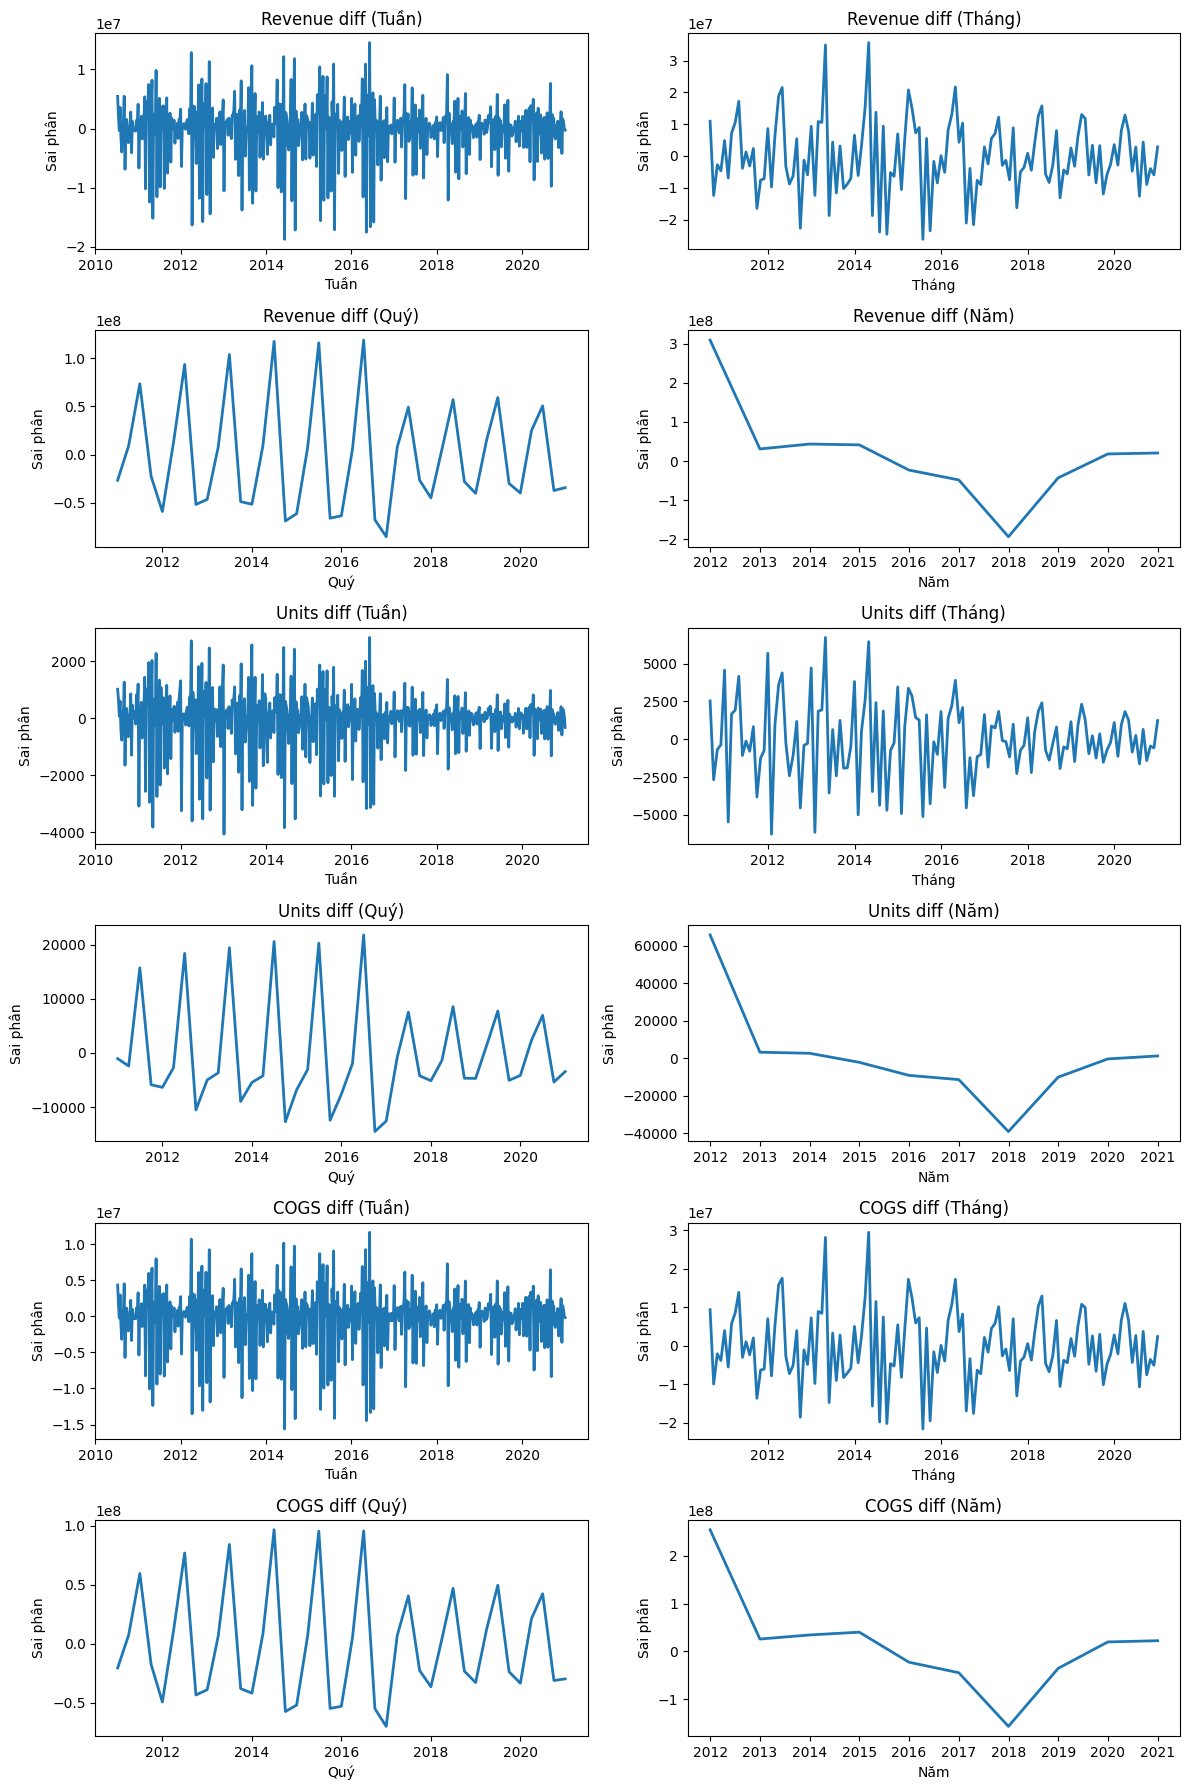

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

def adf_test(series, title=''):
    """
    Thực hiện kiểm định ADF cho chuỗi thời gian và in ra kết quả.
    """
    result = adfuller(series.dropna())
    print(f'ADF Test cho {title}:')
    print(f'  ADF Statistic: {result[0]:.4f}')
    print(f'  p-value: {result[1]:.4f}\n')

def plot_12_subplots_first_diff(df):
    """
    Kiểm chứng tính dừng của chuỗi gốc và chuỗi sai phân bậc 1 cho các chỉ số:
      - Revenue, Units, COGS
    theo 4 tần số: Tuần, Tháng, Quý, Năm.
    """
    # Đảm bảo cột Date là datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Định nghĩa các tần số: (Tên hiển thị, rule resample)
    freq_order = [('Tuần', 'W'), ('Tháng', 'ME'), ('Quý', 'QE'), ('Năm', 'YE')]
    
    # Các chỉ số cần kiểm tra
    series_list = ['Revenue', 'Units', 'COGS']
    
    # Kiểm chứng ADF cho chuỗi gốc và chuỗi sai phân bậc 1, in kết quả.
    print("=== Kiểm định ADF cho chuỗi gốc ===")
    for name in series_list:
        for freq_name, rule in freq_order:
            ts = df.resample(rule, on='Date')[name].sum()
            adf_test(ts, title=f"{name} ({freq_name})")
            
    print("=== Kiểm định ADF cho chuỗi sai phân bậc 1 ===")
    for name in series_list:
        for freq_name, rule in freq_order:
            ts = df.resample(rule, on='Date')[name].sum()
            ts_diff = ts.diff().dropna()
            adf_test(ts_diff, title=f"{name} diff ({freq_name})")
    
    fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 18))
    
    for i, name in enumerate(series_list):
        start_row = i * 2
        for j, (freq_name, rule) in enumerate(freq_order):
            row_idx = start_row if j < 2 else start_row + 1
            col_idx = j if j < 2 else j - 2
            
            # Resample và tính sai phân bậc 1
            ts = df.resample(rule, on='Date')[name].sum()
            ts_diff = ts.diff().dropna()
            
            # Vẽ đường
            axes[row_idx, col_idx].plot(ts_diff.index, ts_diff.values, lw=2)
            axes[row_idx, col_idx].set_title(f"{name} diff ({freq_name})")
            axes[row_idx, col_idx].set_xlabel(freq_name)
            axes[row_idx, col_idx].set_ylabel('Sai phân')
    
    plt.tight_layout()
    plt.show()

plot_12_subplots_first_diff(df)

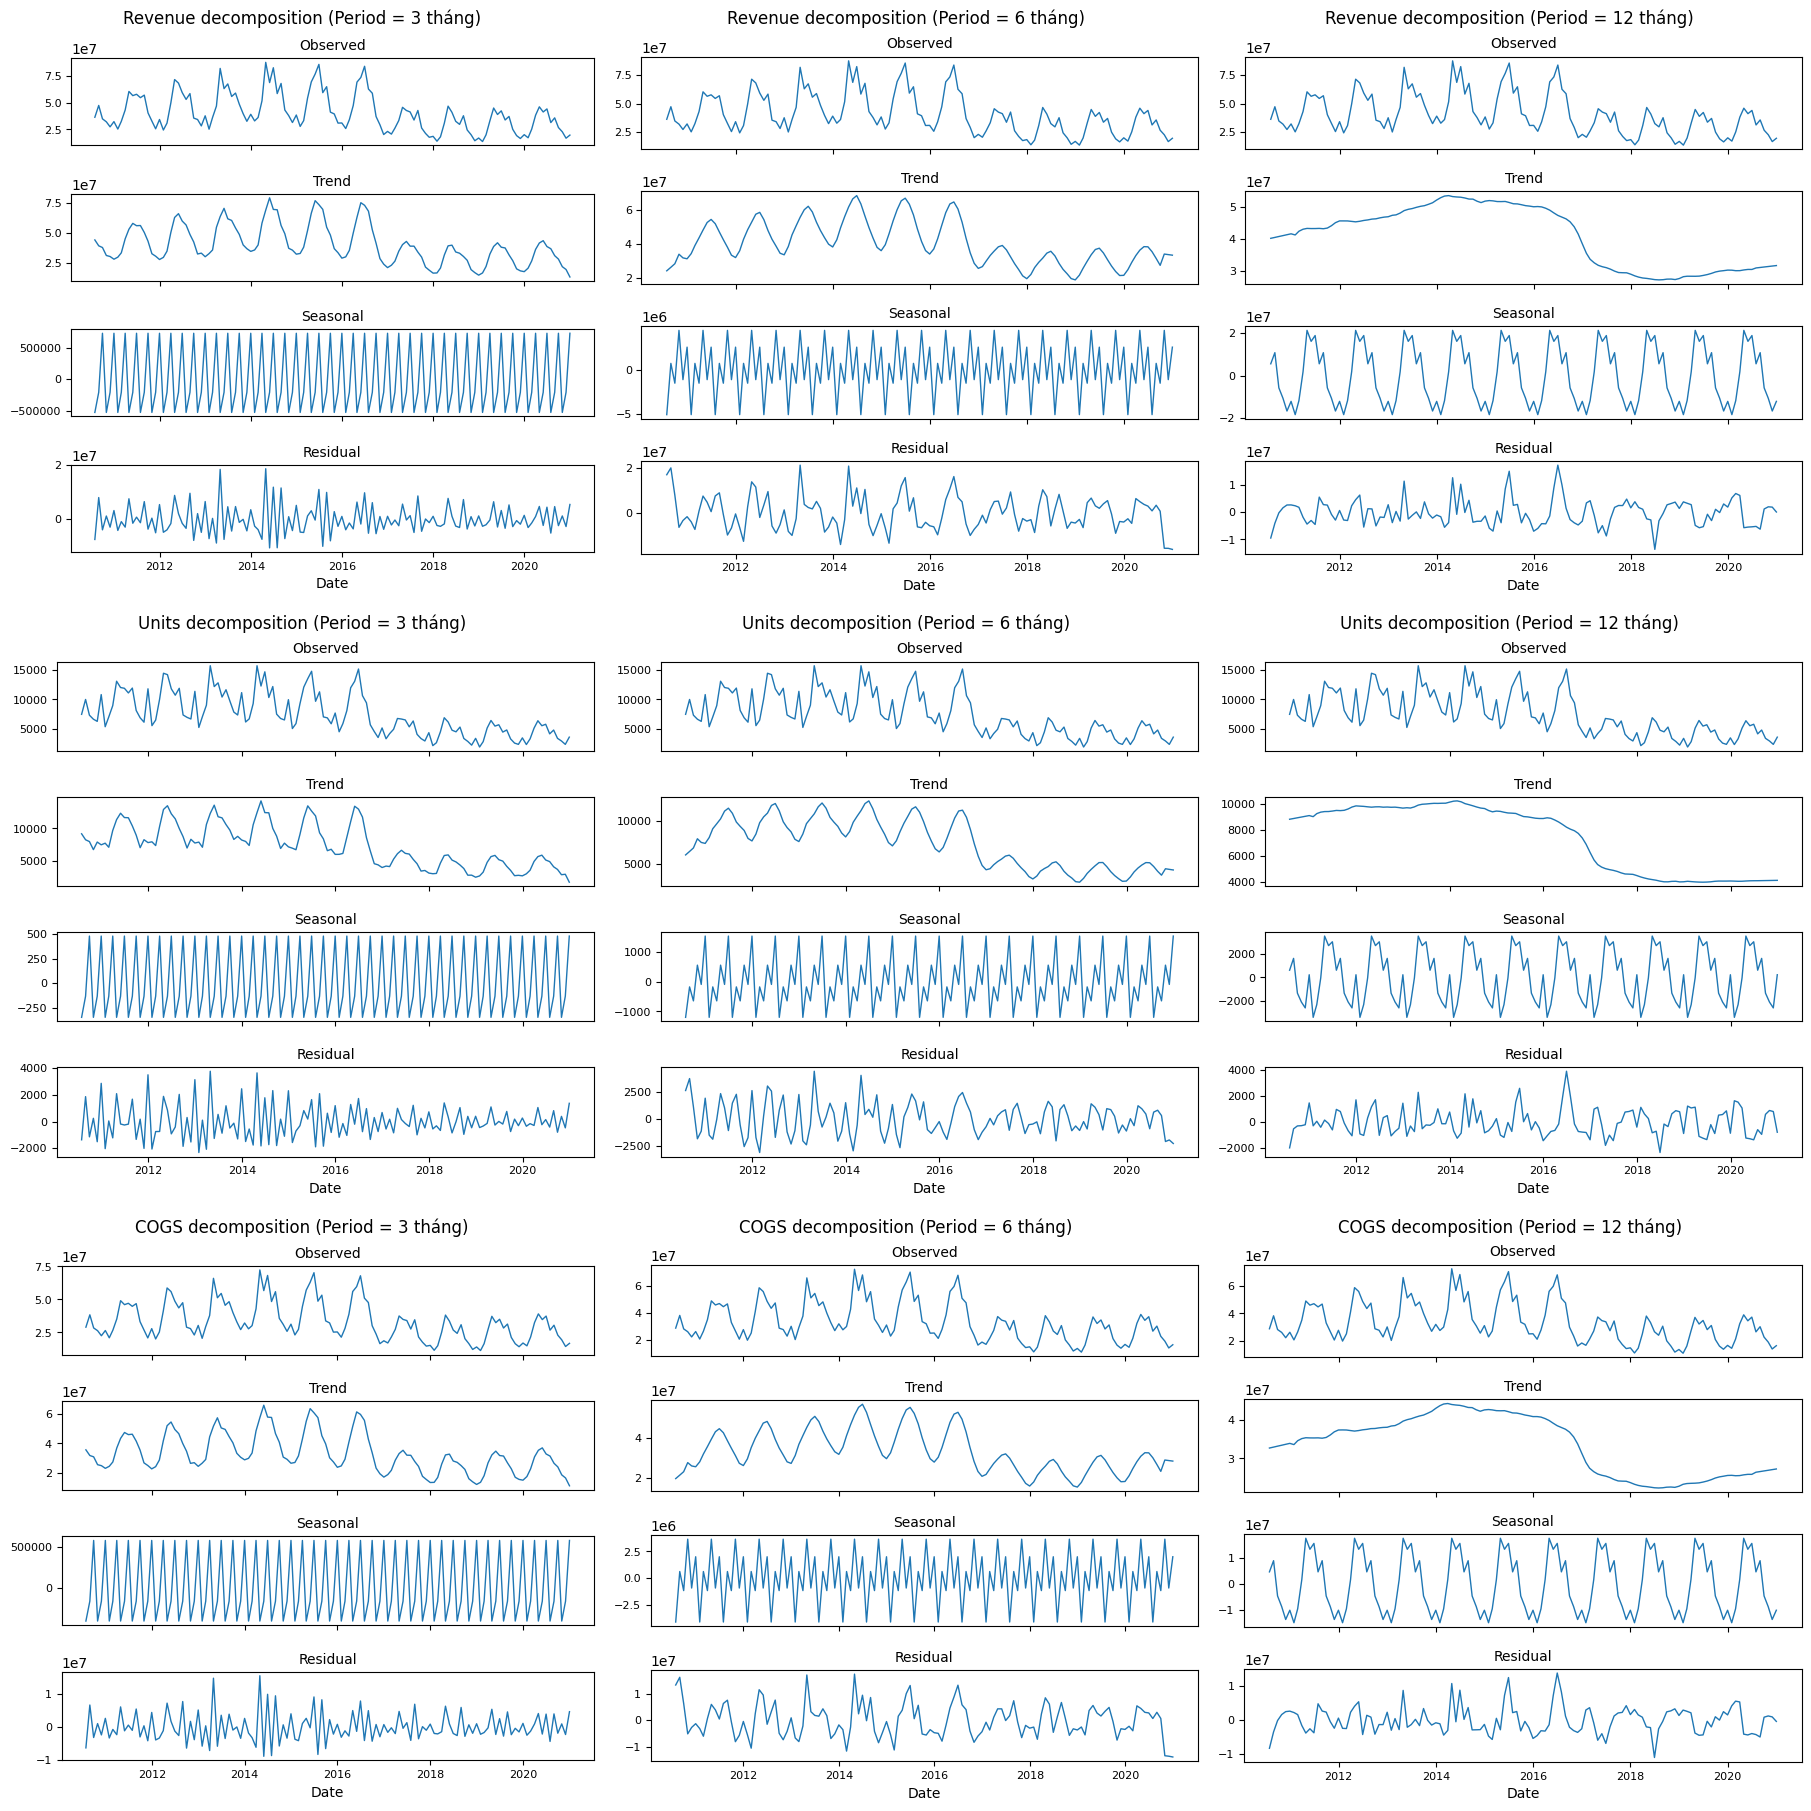

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Đảm bảo cột Date ở định dạng datetime và tổng hợp theo tháng
df['Date'] = pd.to_datetime(df['Date'])
monthly_df = df.resample('M', on='Date')[['Revenue', 'Units', 'COGS']].sum()

# Các chu kỳ cần dùng (period = số tháng)
periods = [3, 6, 12]
# Danh sách các chỉ số
series_list = ['Revenue', 'Units', 'COGS']

# Tạo figure lớn với subfigures: 9 nhóm (3 hàng x 3 cột)
fig = plt.figure(constrained_layout=True, figsize=(18, 18))
subfigs = fig.subfigures(nrows=3, ncols=3)

# Lặp qua từng chỉ số và từng chu kỳ để phân tích và vẽ
for i, series in enumerate(series_list):
    for j, period in enumerate(periods):
        subfig = subfigs[i, j]
        subfig.suptitle(f"{series} decomposition (Period = {period} tháng)", fontsize=12)
        
        # Thực hiện seasonal_decompose cho chuỗi của chỉ số với chu kỳ period
        decomp = seasonal_decompose(monthly_df[series], model='additive', period=period, extrapolate_trend='freq')
        
        # Tạo 4 subplot nhỏ xếp dọc trong mỗi subfigure (1 cột, 4 hàng)
        axes = subfig.subplots(nrows=4, ncols=1, sharex=True)
        
        components = {
            'Observed': decomp.observed,
            'Trend': decomp.trend,
            'Seasonal': decomp.seasonal,
            'Residual': decomp.resid
        }
        for ax, (comp_name, comp_series) in zip(axes, components.items()):
            ax.plot(comp_series.index, comp_series.values, lw=1)
            ax.set_title(comp_name, fontsize=10)
            # Ép tỷ lệ cho mỗi hình nhỏ: tỉ lệ chiều cao/chiều rộng = 1/6 (tức là hình dẹt, dài 6 lần cao)
            ax.set_box_aspect(1/6)
            ax.tick_params(labelsize=8)
            
        # Gắn nhãn trục x cho hình ở dưới cùng của subfigure
        axes[-1].set_xlabel("Date", fontsize=10)

plt.show()


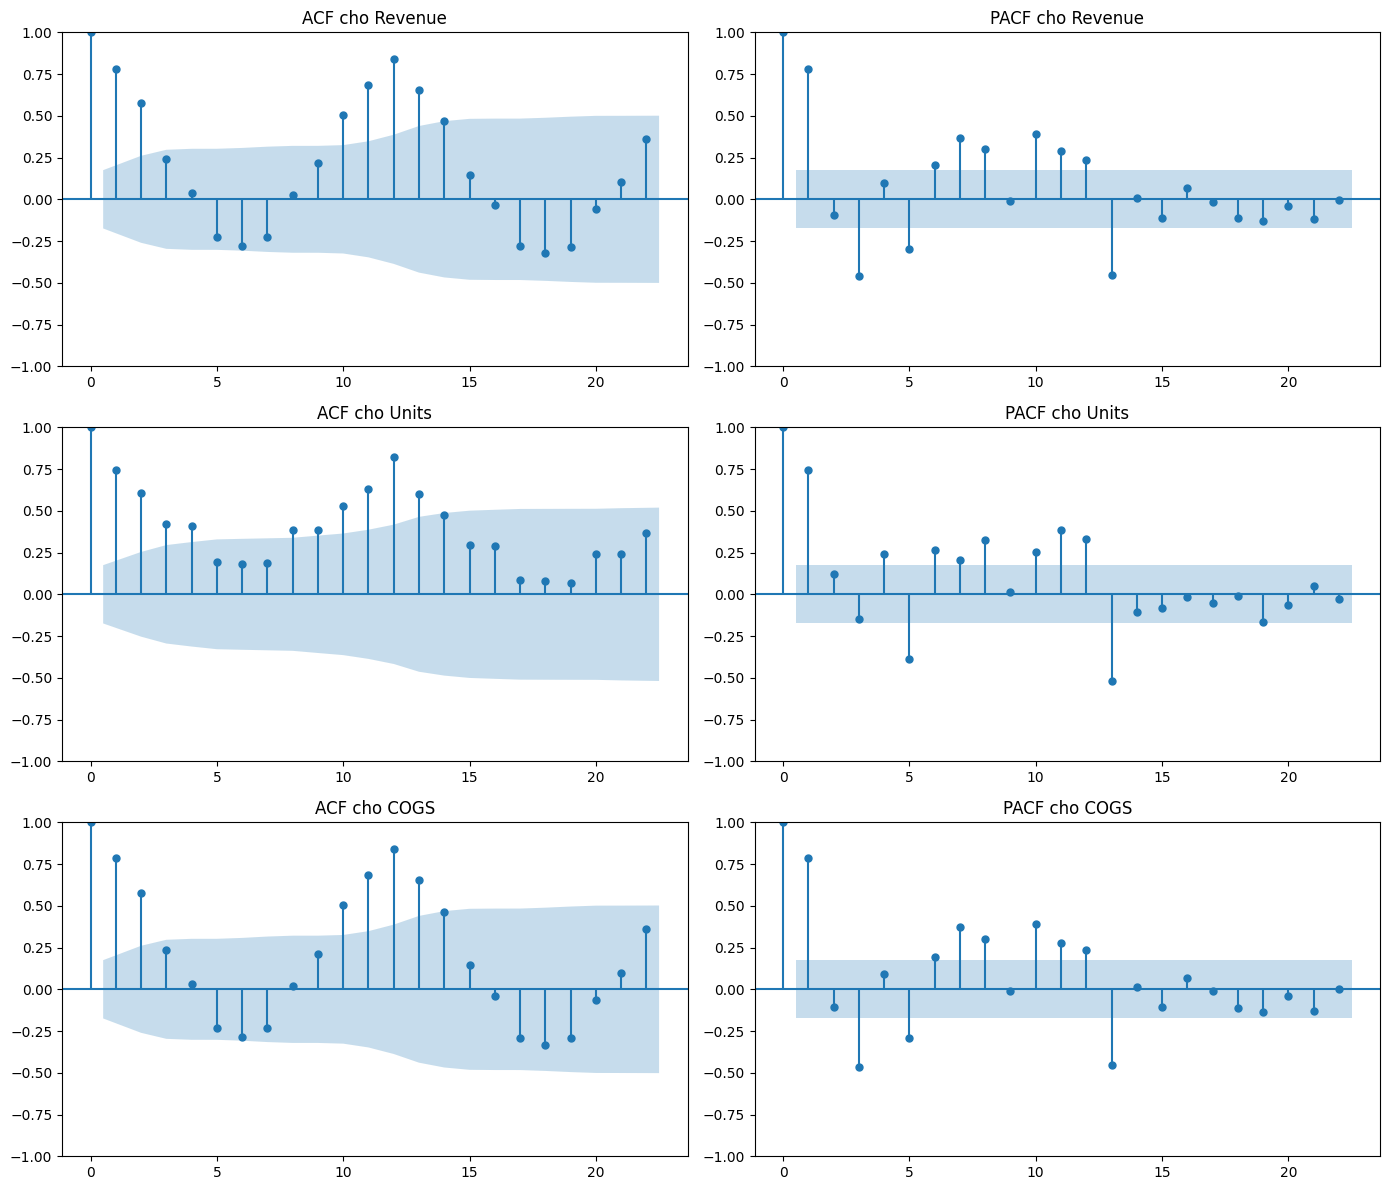

Giá trị ACF và PACF (24 lag đầu) cho từng thuộc tính:

Revenue:
ACF: [ 1.          0.78253044  0.57483995  0.24138824  0.03854897 -0.22363513
 -0.27793742 -0.22422004  0.02766268  0.21581159  0.50429298  0.68701897
  0.84105056  0.65571616  0.46766691  0.14627062 -0.03528366 -0.28177412
 -0.32405937 -0.28534081 -0.05623874  0.10611441  0.36342227  0.51153516
  0.63506347]
PACF: [ 1.          0.78253044 -0.09677368 -0.45895215  0.10042181 -0.29687521
  0.20509598  0.36692875  0.30401443 -0.01240055  0.39365569  0.2867325
  0.23446757 -0.45115497  0.01051076 -0.11342147  0.06742255 -0.01345926
 -0.1107334  -0.12748372 -0.04275481 -0.11851573 -0.00327857 -0.04715796
 -0.02717493]

Units:
ACF: [1.         0.74480203 0.60884652 0.42382143 0.41019968 0.19323134
 0.18428376 0.18579702 0.38431619 0.38560605 0.52818368 0.63333421
 0.82022196 0.59999728 0.47562332 0.29757431 0.28802203 0.08353663
 0.08141933 0.06525283 0.24280054 0.24048131 0.36504629 0.44609877
 0.59104458]
PACF: [ 1.          

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Đảm bảo cột Date có định dạng datetime
df['Date'] = pd.to_datetime(df['Date'])
# Tổng hợp dữ liệu theo tháng
monthly_df = df.resample('M', on='Date')[['Revenue', 'Units', 'COGS']].sum()

# Danh sách thuộc tính để thực hiện ACF, PACF
attributes = ['Revenue', 'Units', 'COGS']

# Tạo figure với 6 subplot: 3 hàng x 2 cột (trái: ACF, phải: PACF)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))

for i, attr in enumerate(attributes):
    # Vẽ ACF cho thuộc tính attr
    plot_acf(monthly_df[attr].dropna(), ax=axes[i, 0], title=f"ACF cho {attr}")
    # Vẽ PACF cho thuộc tính attr (sử dụng method 'ywm' cho PACF)
    plot_pacf(monthly_df[attr].dropna(), ax=axes[i, 1], title=f"PACF cho {attr}", method='ywm')
    
plt.tight_layout()
plt.show()

# In ra một vài giá trị ACF, PACF của từng thuộc tính (ví dụ giá trị 5 lag đầu tiên)
from statsmodels.tsa.stattools import acf, pacf

print("Giá trị ACF và PACF (24 lag đầu) cho từng thuộc tính:")
for attr in attributes:
    acf_vals = acf(monthly_df[attr].dropna(), nlags=24)
    pacf_vals = pacf(monthly_df[attr].dropna(), nlags=24, method='ywm')
    print(f"\n{attr}:")
    print("ACF:", acf_vals)
    print("PACF:", pacf_vals)
